##### Copyright 2022 AssemblyAI Team.

# PyTorch Crash Course

#### Overview:

1. Tensor Basics
  - Create, Operations, NumPy, GPU Support
2. Autograd
  - Linear regression example
3. Training Loop with: Model, Loss & Optimizer
  - A typical PyTorch training pipeline
4. Neural Network
  - Also: GPU, Datasets, DataLoader, Transforms & Evaluation
5. Convolutional Neural Network
  - Also: Save/Load model

Created by [AssemblyAI](https://www.assemblyai.com)

Watch the video:

 [![Alt text](https://img.youtube.com/vi/OIenNRt2bjg/hqdefault.jpg)](https://youtu.be/mYUyaKmvu6Y)

## 1. Tensors

Everything in PyTorch is based on Tensor operations. A Tensor is a multi-dimensional matrix containing elements of a single data type:


In [ ]:
import torch

# torch.empty(size): uninitiallized
x = torch.empty(1) # scalar
print("empty(1):", x)
x = torch.empty(3) # vector
print("empty(3):",x)
x = torch.empty(2, 3) # matrix
print("empty(2,3):",x)
x = torch.empty(2, 2, 3) # tensor, 3 dimensions
#x = torch.empty(2,2,2,3) # tensor, 4 dimensions
print("empty(2, 2, 3):",x)

# torch.rand(size): random numbers [0, 1]
x = torch.rand(5, 3)
print("rand(5,3):", x)

# torch.zeros(size), fill with 0
# torch.ones(size), fill with 1
x = torch.zeros(5, 3)
print("zeros(5,3):", x)

In [ ]:
# check size
print("size", x.size())  # x.size(0)
print("shape", x.shape)  # x.shape[0]

In [ ]:
# check data type
print(x.dtype)

# specify types, float32 default
x = torch.zeros(5, 3, dtype=torch.float16)
print(x)

# check type
print(x.dtype)

In [ ]:
# construct from data
x = torch.tensor([5.5, 3])
print(x, x.dtype)

In [ ]:
# requires_grad argument
# This will tell pytorch that it will need to calculate the gradients for this tensor
# later in your optimization steps
# i.e. this is a variable in your model that you want to optimize
x = torch.tensor([5.5, 3], requires_grad=True)
print(x)

#### Operations with Tensors

In [ ]:
# Operations
x = torch.ones(2, 2)
y = torch.rand(2, 2)

# elementwise addition
z = x + y
# torch.add(x,y)

# in place addition, everythin with a trailing underscore is an inplace operation
# i.e. it will modify the variable
# y.add_(x)

print(x)
print(y)
print(z)

In [ ]:
# subtraction
z = x - y
z = torch.sub(x, y)

# multiplication
z = x * y
z = torch.mul(x,y)

# division
z = x / y
z = torch.div(x,y)

In [ ]:
# Slicing
x = torch.rand(5,3)
print(x)
print("x[:, 0]", x[:, 0]) # all rows, column 0
print("x[1, :]", x[1, :]) # row 1, all columns
print("x[1, 1]", x[1,1]) # element at 1, 1

# Get the actual value if only 1 element in your tensor
print("x[1,1].item()", x[1,1].item())

In [ ]:
# Reshape with torch.view()
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
# if -1 it pytorch will automatically determine the necessary size
print(x.size(), y.size(), z.size())

#### NumPy

Converting a Torch Tensor to a NumPy array and vice versa is very easy

In [ ]:
a = torch.ones(5)
print(a)

# torch to numpy with .numpy()
b = a.numpy()
print(b)
print(type(b))

In [ ]:
# Careful: If the Tensor is on the CPU (not the GPU),
# both objects will share the same memory location, so changing one
# will also change the other
a.add_(1)
print(a)
print(b)

In [ ]:
# numpy to torch with .from_numpy(x), or torch.tensor() to copy it
import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
c = torch.tensor(a)
print(a)
print(b)
print(c)

# again be careful when modifying
a += 1
print(a)
print(b)
print(c)

#### GPU Support

By default all tensors are created on the CPU. But we can also move them to the GPU (if it's available ), or create them directly on the GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x = torch.rand(2,2).to(device)  # move tensors to GPU device
#x = x.to("cpu")
#x = x.to("cuda")

x = torch.rand(2,2, device=device)  # or directy create them on GPU

## 2. Autograd

The autograd package provides automatic differentiation for all operations on Tensors. Generally speaking, *torch.autograd* is an engine for computing the vector-Jacobian product. It computes partial derivates while applying the chain rule.

Set `requires_grad = True`:

In [ ]:
import torch

# requires_grad = True -> tracks all operations on the tensor.
x = torch.randn(3, requires_grad=True)
y = x + 2

# y was created as a result of an operation, so it has a grad_fn attribute.
# grad_fn: references a Function that has created the Tensor
print(x) # created by the user -> grad_fn is None
print(y)
print(y.grad_fn)

In [ ]:
# Do more operations on y
z = y * y * 3
print(z)
z = z.mean()
print(z)

In [ ]:
# Let's compute the gradients with backpropagation
# When we finish our computation we can call .backward() and have all the gradients computed automatically.
# The gradient for this tensor will be accumulated into .grad attribute.
# It is the partial derivate of the function w.r.t. the tensor

print(x.grad)
z.backward()
print(x.grad) # dz/dx

# !!! Careful!!! backward() accumulates the gradient for this tensor into .grad attribute.
# !!! We need to be careful during optimization !!! optimizer.zero_grad()

#### Stop a tensor from tracking history:
For example during the training loop when we want to update our weights, or after training during evaluation. These operations should not be part of the gradient computation. To prevent this, we can use:

- `x.requires_grad_(False)`
- `x.detach()`
- wrap in `with torch.no_grad():`

In [ ]:
# .requires_grad_(...) changes an existing flag in-place.
a = torch.randn(2, 2)
b = (a * a).sum()
print(a.requires_grad)
print(b.grad_fn)

a.requires_grad_(True)
b = (a * a).sum()
print(a.requires_grad)
print(b.grad_fn)

In [ ]:
# .detach(): get a new Tensor with the same content but no gradient computation:
a = torch.randn(2, 2, requires_grad=True)
b = a.detach()
print(a.requires_grad)
print(b.requires_grad)

In [ ]:
# wrap in 'with torch.no_grad():'
a = torch.randn(2, 2, requires_grad=True)
print(a.requires_grad)
with torch.no_grad():
    b = a ** 2
    print(b.requires_grad)

## Gradient Descent Autograd
Linear Regression example:

$f(x) = w * x + b$

here : `f(x) = 2 * x`

In [ ]:
import torch

# Linear regression
# f = w * x  + b
# here : f = 2 * x

X = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8], dtype=torch.float32)
Y = torch.tensor([2, 4, 6, 8, 10, 12, 14, 16], dtype=torch.float32)

w = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

# model output
def forward(x):
    return w * x

# loss = MSE
def loss(y, y_pred):
    return ((y_pred - y)**2).mean()

X_test = 5.0

print(f'Prediction before training: f({X_test}) = {forward(X_test).item():.3f}')

In [ ]:
# Training
learning_rate = 0.01
n_epochs = 100

for epoch in range(n_epochs):
    # predict = forward pass
    y_pred = forward(X)

    # loss
    l = loss(Y, y_pred)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    #w.data = w.data - learning_rate * w.grad
    with torch.no_grad():
      w -= learning_rate * w.grad

    # zero the gradients after updating
    w.grad.zero_()

    if (epoch+1) % 10 == 0:
        print(f'epoch {epoch+1}: w = {w.item():.3f}, loss = {l.item():.3f}')

print(f'Prediction after training: f({X_test}) = {forward(X_test).item():.3f}')

## 3. Model, Loss & Optimizer

A typical PyTorch pipeline looks like this:

1. Design model (input, output, forward pass with different layers)
2. Construct loss and optimizer
3. Training loop:
  - Forward = compute prediction and loss
  - Backward = compute gradients
  - Update weights

In [ ]:
import torch
import torch.nn as nn

# Linear regression
# f = w * x
# here : f = 2 * x

# 0) Training samples, watch the shape!
X = torch.tensor([[1], [2], [3], [4], [5], [6], [7], [8]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8], [10], [12], [14], [16]], dtype=torch.float32)

n_samples, n_features = X.shape
print(f'n_samples = {n_samples}, n_features = {n_features}')

# 0) create a test sample
X_test = torch.tensor([5], dtype=torch.float32)

In [ ]:
# 1) Design Model, the model has to implement the forward pass!

# Here we could simply use a built-in model from PyTorch
# model = nn.Linear(input_size, output_size)

class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        # define different layers
        self.lin = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.lin(x)


input_size, output_size = n_features, n_features

model = LinearRegression(input_size, output_size)

print(f'Prediction before training: f({X_test.item()}) = {model(X_test).item():.3f}')

# 2) Define loss and optimizer
learning_rate = 0.01
n_epochs = 100

loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 3) Training loop
for epoch in range(n_epochs):
    # predict = forward pass with our model
    y_predicted = model(X)

    # loss
    l = loss(Y, y_predicted)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    optimizer.step()

    # zero the gradients after updating
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        w, b = model.parameters() # unpack parameters
        print('epoch ', epoch+1, ': w = ', w[0][0].item(), ' loss = ', l.item())

print(f'Prediction after training: f({X_test.item()}) = {model(X_test).item():.3f}')

## 4. First Neural Net
GPU, Datasets, DataLoader, Transforms, Neural Net, Training & Evaluation


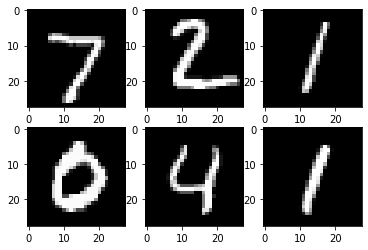

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [ ]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass and loss calculation
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.3486
Epoch [1/2], Step [200/600], Loss: 0.1807
Epoch [1/2], Step [300/600], Loss: 0.2612
Epoch [1/2], Step [400/600], Loss: 0.1134
Epoch [1/2], Step [500/600], Loss: 0.1875
Epoch [1/2], Step [600/600], Loss: 0.3031
Epoch [2/2], Step [100/600], Loss: 0.0671
Epoch [2/2], Step [200/600], Loss: 0.1215
Epoch [2/2], Step [300/600], Loss: 0.1317
Epoch [2/2], Step [400/600], Loss: 0.0537
Epoch [2/2], Step [500/600], Loss: 0.0350
Epoch [2/2], Step [600/600], Loss: 0.0633


In [ ]:
# Test the model: we don't need to compute gradients
with torch.no_grad():
    n_correct = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs = model(images)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test images: {100*acc} %')

Accuracy of the network on the 10000 test images: 96.92 %


## 5. CNN

This section covers:

- Convolutional Layers
- MaxPooling
- Save/Load model

Files already downloaded and verified
Files already downloaded and verified


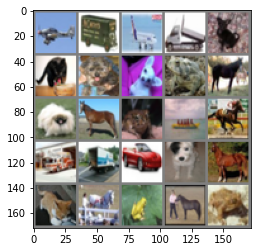

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(imgs):
    imgs = imgs / 2 + 0.5   # unnormalize
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.show()

# one batch of random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
imshow(img_grid)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*4*4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # N, 3, 32, 32
        x = F.relu(self.conv1(x))   # -> N, 32, 30, 30
        x = self.pool(x)            # -> N, 32, 15, 15
        x = F.relu(self.conv2(x))   # -> N, 64, 13, 13
        x = self.pool(x)            # -> N, 64, 6, 6
        x = F.relu(self.conv3(x))   # -> N, 64, 4, 4
        x = torch.flatten(x, 1)     # -> N, 1024
        x = F.relu(self.fc1(x))     # -> N, 64
        x = self.fc2(x)             # -> N, 10
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

[1] loss: 1.472
[2] loss: 1.105
[3] loss: 0.942
[4] loss: 0.835
[5] loss: 0.762
[6] loss: 0.697
[7] loss: 0.649
[8] loss: 0.603
[9] loss: 0.561
[10] loss: 0.527
Finished Training


In [ ]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        n_correct2 += (predicted2 == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the model: {acc} %')

    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')

Accuracy of the model: 71.29 %
Accuracy of the loaded model: 71.29 %
